In [ ]:
#13.2.1 오토인코더란

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_image = tf.keras.layers.Input(shape=(784,))
encoded_input = tf.keras.layers.Dense(32, activation='relu')(input_image)
decoded_output = tf.keras.layers.Dense(784, activation='sigmoid')(encoded_input)
autoencoder = tf.keras.models.Model(input_image, decoded_output)

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape((len(X_train),np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test),np.prod(X_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
autoencoder.fit(
    X_train,
    X_train,
    epochs = 30,
    batch_size = 256, 
    shuffle = True, 
    validation_data = (X_test, X_test))

Epoch 1/30
235/235 [==============================] - 4s 5ms/step - loss: 0.3862 - val_loss: 0.1896
Epoch 2/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1787 - val_loss: 0.1530
Epoch 3/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1490 - val_loss: 0.1330
Epoch 4/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1315 - val_loss: 0.1206
Epoch 5/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1198 - val_loss: 0.1121
Epoch 6/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1122 - val_loss: 0.1063
Epoch 7/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1064 - val_loss: 0.1023
Epoch 8/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.0993
Epoch 9/30
235/235 [==============================] - 1s 3ms/step - loss: 0.0999 - val_loss: 0.0972
Epoch 10/30
235/235 [==============================] - 1s 3ms/step - loss: 0.0982 - val_loss: 0.0957

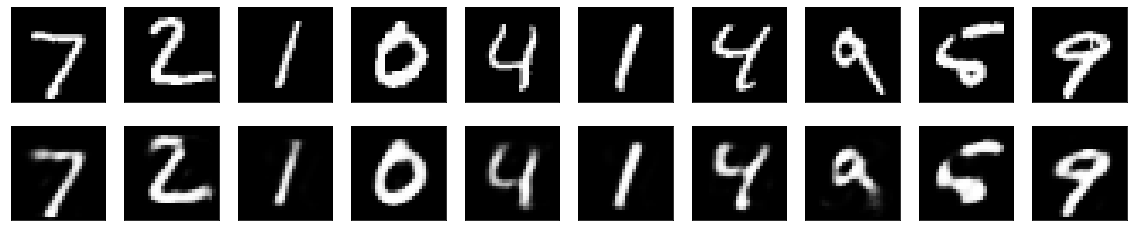

In [ ]:
reconstructed_img = autoencoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#13.2.2 변형 오토인코더(Variational AutoEncoder)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
TRAIN_BUF=60000
TEST_BUF=10000
BATCH_SIZE=512
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [ ]:
(train_images, train_lebels), (test_images, test_lebels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(512)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(512)
)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def loss_function(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))
        return recon_loss, latent_loss

    def gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [ ]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

In [ ]:
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

In [ ]:
example_data = next(iter(test_dataset))
def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, 2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

In [ ]:
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

Epoch: 49 | recon_loss: 22.271812438964844 | latent_loss: 4.345654487609863


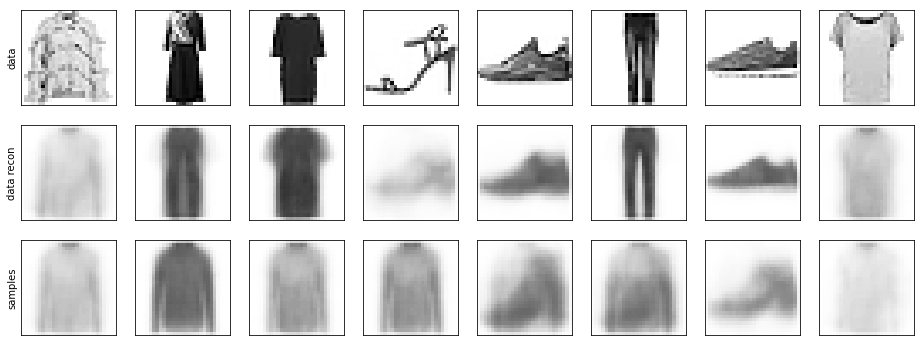

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)
        loss = []
        
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
): 
        loss.append(model.loss_function(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0) 
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )
    
    plot_reconstruction(model, example_data)
    

In [ ]:
#13.3.2 GAN 구현하기

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Dense, Dropout,LeakyReLU, Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras import Model,Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

In [ ]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(7*7*256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    
    generator.add(Reshape((7, 7, 256)))
    
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))
       
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))
    
    return generator
g=create_generator()
g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)        

In [ ]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))   
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    final_loss = real_loss + fake_loss
    return final_loss
  
def G_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [ ]:
G_optimizer = tf.keras.optimizers.Adam()
D_optimizer = tf.keras.optimizers.Adam()

In [ ]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 1

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [ ]:
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='rainbow')

In [ ]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if epoch % 10 == 0:
            generate_images(generator,epoch + 1,seed)
        print ('에포크 {} 은/는 {} 초'.format(epoch + 1, time.time()-start))
    generate_images(generator,epochs,seed)

에포크 1 은/는 5.392504930496216 초
에포크 2 은/는 3.1020350456237793 초
에포크 3 은/는 3.124788284301758 초
에포크 4 은/는 3.1424360275268555 초
에포크 5 은/는 3.16317081451416 초
에포크 6 은/는 3.162005662918091 초
에포크 7 은/는 3.1762502193450928 초
에포크 8 은/는 3.1847727298736572 초
에포크 9 은/는 3.1936678886413574 초
에포크 10 은/는 3.197918176651001 초
에포크 11 은/는 3.3585569858551025 초
에포크 12 은/는 3.181480646133423 초
에포크 13 은/는 3.1601345539093018 초
에포크 14 은/는 3.153461456298828 초
에포크 15 은/는 3.1481010913848877 초
에포크 16 은/는 3.139927625656128 초
에포크 17 은/는 3.1312062740325928 초
에포크 18 은/는 3.12400221824646 초
에포크 19 은/는 3.120089292526245 초
에포크 20 은/는 3.1135494709014893 초
에포크 21 은/는 3.2867376804351807 초
에포크 22 은/는 3.109586238861084 초
에포크 23 은/는 3.108982563018799 초
에포크 24 은/는 3.1095526218414307 초
에포크 25 은/는 3.109804630279541 초
에포크 26 은/는 3.114556074142456 초
에포크 27 은/는 3.1168994903564453 초
에포크 28 은/는 3.1219985485076904 초
에포크 29 은/는 3.1245129108428955 초
에포크 30 은/는 3.128776788711548 초


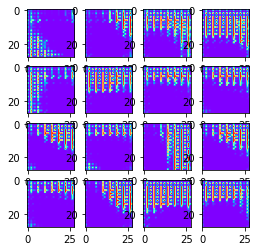

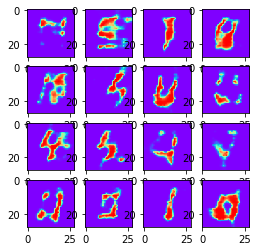

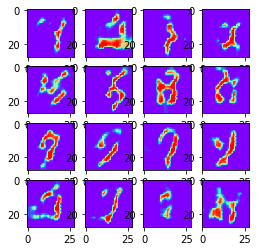

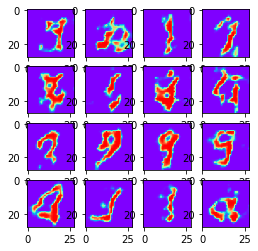

In [ ]:
train_GAN(train_dataset, 30)